## importing dataset

In [ ]:
!pip install -q kaggle 

In [ ]:
!mkdir -p ~/ .kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:39<00:00, 160MB/s]
100% 6.31G/6.31G [00:40<00:00, 169MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/histopathologic-cancer-detection.zip','r')
zip.extractall('/content')
zip.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

In [ ]:
from keras.utils import image_dataset_from_directory as idfd

In [ ]:
import pandas as pd
df = pd.read_csv('/content/train_labels.csv')

In [ ]:
df.isnull().sum()

id       0
label    0
dtype: int64

In [ ]:
len(df)

220025

In [ ]:
import os

dir_path = '/content/train'
image_exts = ['.tif']  # list of image extensions to count

num_images = sum([len(files) for r, d, files in os.walk(dir_path) if any(file.lower().endswith(tuple(image_exts)) for file in files)])

print(f'Total number of images in {dir_path}: {num_images}')


Total number of images in /content/train: 220025


In [ ]:
import cv2
import os

source_dir = '/content/train'
dest_dir = '/content/train1'

os.makedirs(dest_dir, exist_ok=True)


# create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# loop over all .tif files in source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.tif'):
        # read the image using OpenCV
        img = cv2.imread(os.path.join(source_dir, filename))

        # convert to RGB color space if necessary
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # save as .jpg in destination directory
        dest_path = os.path.join(dest_dir, filename.replace('.tif', '.jpg'))
        cv2.imwrite(dest_path, img)


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2)



# Define the source directories and destination directories
traindir = "/content/train_new"
valdir = "/content/val_new"
traincancer = "/content/train_new/cancer"
trainnoncancer = "/content/train_new/non_cancer"
valcancer = "/content/val_new/cancer"
valnoncancer = "/content/val_new/non_cancer"
# Create the destination directories if they don't exist
os.makedirs(traindir, exist_ok=True)
os.makedirs(valdir, exist_ok=True)
os.makedirs(trainnoncancer, exist_ok=True)
os.makedirs(traincancer, exist_ok=True)
os.makedirs(valnoncancer, exist_ok=True)
os.makedirs(valcancer, exist_ok=True)


# Copy the images to the destination directories based on their labels
for index, row in train_df.iterrows():
    filename = row["id"]+'.jpg'
    label = row["label"]
    if label == 0:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(trainnoncancer, filename)
    else:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(traincancer, filename)
    shutil.copyfile(src_path, dest_path)

  
for index, row in val_df.iterrows():
    filename = row["id"]+'.jpg'
    label = row["label"]
    if label == 0:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(valnoncancer, filename)
    else:
        src_path = os.path.join('/content/train1', filename)
        dest_path = os.path.join(valcancer, filename)
    shutil.copyfile(src_path, dest_path)


In [ ]:
from keras.utils import image_dataset_from_directory as idfd

In [ ]:
train_ds = idfd(
    directory = '/content/train_new',
    labels = 'inferred',
    label_mode = 'int',
    batch_size= 32,
    image_size = (256,256)
)

validation_ds = idfd(
    directory = '/content/val_new',
    labels = 'inferred',
    label_mode = 'int',
    batch_size= 32,
    image_size = (256,256)
)

Found 211058 files belonging to 2 classes.
Found 44005 files belonging to 2 classes.


In [ ]:
def normalise_process(image,label):
  image = tf.cast(image/255,tf.float32)
  return image,label

In [ ]:
train_ds = train_ds.map(normalise_process)
validation_ds = validation_ds.map(normalise_process)

In [ ]:
from keras.layers import BatchNormalization,Dropout

In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation = 'relu',input_shape =(256,256,3) ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
6596/6596 [==============================] - 712s 106ms/step - loss: 0.5493 - accuracy: 0.8048 - val_loss: 0.3927 - val_accuracy: 0.8286
Epoch 2/10
6596/6596 [==============================] - 685s 104ms/step - loss: 0.3653 - accuracy: 0.8476 - val_loss: 0.3846 - val_accuracy: 0.8307
Epoch 3/10
6596/6596 [==============================] - 686s 104ms/step - loss: 0.3269 - accuracy: 0.8657 - val_loss: 0.5981 - val_accuracy: 0.7700
Epoch 4/10
6596/6596 [==============================] - 689s 104ms/step - loss: 0.2960 - accuracy: 0.8792 - val_loss: 0.2642 - val_accuracy: 0.8953
Epoch 5/10
6596/6596 [==============================] - 702s 106ms/step - loss: 0.2796 - accuracy: 0.8880 - val_loss: 0.2813 - val_accuracy: 0.8899
Epoch 6/10
6596/6596 [==============================] - 669s 101ms/step - loss: 0.2546 - accuracy: 0.8980 - val_loss: 0.2941 - val_accuracy: 0.8787
Epoch 7/10
6596/6596 [==============================] - 692s 105ms/step - loss: 0.2405 - accuracy: 0.9049 - val_

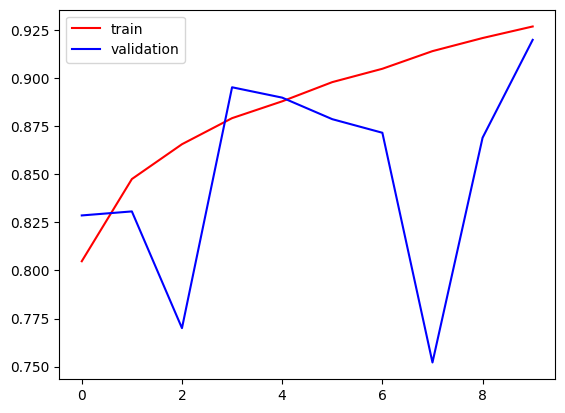

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()



In [ ]:
import os

directory = '/content/train'
invalid_files = []
valid_files= []

for filename in df['id']:
    filepath = os.path.join(directory, filename + '.tif')
    if not os.path.exists(filepath):
        invalid_files.append(filename)
    else:
      valid_files.append(filename)

print(len(valid_files))


220025


In [ ]:
model.save('model1.h5')

In [ ]:
from google.colab import files

files.download('/content/model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>